In [6]:
from __future__ import division
import os
from os import listdir
from os.path import isfile, join
import time
from time import gmtime, strftime
import random

import torch 
from torch import autograd, optim, nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from utils import *
%matplotlib inline 


saveplots = False

if mazetype=='none':
    pathvar = './valplots/grid/{}/'.format(obs_rho)
    figpath = './figures/grid/{}/'.format(obs_rho)
else: 
    pathvar = './valplots/{}/'.format(mazetype)
    figpath = './figures/{}/'.format(mazetype)

if not os.path.exists(figpath):
    os.makedirs(figpath)
if saveplots:
    if not os.path.exists(pathvar):
        os.makedirs(pathvar)

In [7]:
# Define Agent 
class AC_Net(nn.Module):
    def __init__(self, dims):
        super(AC_Net, self).__init__()
        # dims is a list of dimensions of each layer [dimension_of_input, dim_of_hiddenlayer1, ... dim_of_hiddenlayerN, dim_of_output]
        self.layers = dims
        if len(dims)>2: 
            self.hidden = []
            for i in range(len(dims)-2):
                self.hidden.append(nn.Linear(dims[i], dims[i+1]))
            self.h_layers = nn.ModuleList(self.hidden)
            
        self.p_in = nn.Linear(dims[-2],dims[-1])
        self.v_in = nn.Linear(dims[-2],1)
        
    def forward(self, x):
        if len(self.layers)>2:
            for i in range(len(self.hidden)):
                x = F.sigmoid(self.hidden[i](x))
        pol = F.softmax(self.p_in(x))
        val = self.v_in(x)

        return pol, val
    
    
def finish_episode(episode_data):
    R = 0
    saved_actions = model.saved_actions
    value_loss = 0
    rewards = []
    for r in model.rewards[::-1]:
        R = r + man_gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    for (action, value), r in zip(saved_actions, rewards):
        reward = r - value.data[0,0]
        action.reinforce(reward)
        value_loss += F.smooth_l1_loss(value, Variable(torch.Tensor([r])))
    optimizer.zero_grad()
    final_nodes = [value_loss] + list(map(lambda p: p.action, saved_actions))
    gradients = [torch.ones(1)] + [None] * len(saved_actions)
    autograd.backward(final_nodes, gradients)
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

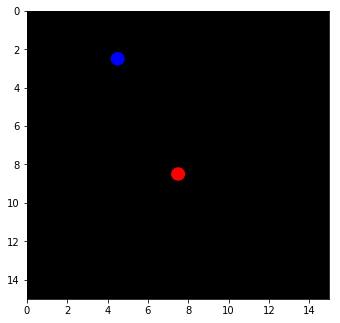

In [8]:
#========================
# Environment Parameters
#======================== 
height = 15
width = 15

mazetype = 'none'
#obstacle density
obs_rho = 0

#place cells
place_cells = 700
#place cell full width half max (must be <1)
fwhm = .2

#make environment
maze = gridworld([height, width],rho=obs_rho,num_pc=place_cells, pc_fwhm=fwhm, maze_type=mazetype)

make_env_plots(maze,1,0,0)

In [9]:
#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 100000

NUM_EVENTS = 300

discount_factor = 0.98
port_shift = 'none'

#agent parameters
dims = [len(maze.net_state[0]),30, len(maze.actionlist)]
model = AC_Net(dims)

#learning parameters

eta = 1e-2 #gradient descent learning rate
opt = optim.SGD(model.parameters(), lr = eta)

In [5]:
# Single run of NUM_TRIALS each with NUM_EVENTS
print_freq = 1./10

#steps_rwd = []
# trialtime = [] #track how many steps into trial before done == True

total_reward = [] #track total reward achieved in trial 
total_loss = [[],[]]

# data frames for value and policy maps
val_maps = []
p_field = np.zeros((height, width), dtype=[('action_taken', 'i4'),('taken_prob', 'f4'), ('likely_action', 'i4'),('likely_prob', 'f4'), ('timestep', 'i4')])

# record current time before beginning of trial
print strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
blocktime = time.time()

# loop over total number of trials 
for i in xrange(NUM_TRIALS):
        start_time = time.time()

        _ep_buffer = []
        reward_sum = 0

        # reset the environment, initialize agent position and reset value map
        maze.start_trial()
        maze.value_map = maze.init_value_map
        
        # get inital state
        state = autograd.Variable(torch.FloatTensor(maze.net_state))
        
        for j in xrange(NUM_EVENTS): 
            # get policy and value estimate in order to select next action
            policy_, value_ = model(state)
            
            policy = policy_.data[0]
            val = value_.data[0]
            
            maze.value_map[maze.cur_state[1]][maze.cur_state[0]] = val

            # select action
            choice = np.random.choice(np.arange(len(policy)), 1, p=list(policy))[0]
            action = maze.actionlist[choice]
            choice_prob = policy[choice]

            p_field[maze.cur_state[1]][maze.cur_state[0]] = (choice, list(policy)[choice], list(policy).index(max(list(policy))), max(list(policy)), i)
            
            # get new state of the environment and reward from action 
            if j < NUM_EVENTS:
                next_state = maze.move(action)

            rwd = maze.rwd

            # store buffer of agents experiences so that later we can calulate returns/etc. backwards through time
            _ep_buffer.append([state,choice,rwd,next_state, val, choice_prob])

            # update state
            state = autograd.Variable(torch.FloatTensor(next_state))

            reward_sum += rwd
            
            #if maze.done == True: 
            #    trialtime.append(j)
            #    break
            #elif j == NUM_EVENTS-1:
            #    trialtime.append(NUM_EVENTS)
        # make data storage useable type 
        _ep_buffer = np.array(_ep_buffer)
        # compute returns
        _returns = torch.FloatTensor(discount_rwds(_ep_buffer[:,2], gamma=discount_factor))
        _values = torch.FloatTensor(_ep_buffer[:,4])
        rpe = _returns - _values
        
        responsible_outputs = torch.FloatTensor(_ep_buffer[:,5])
        
        # LOSS FUNCTIONS
        critic_loss = 0.5*(rpe).pow(2).mean()
        actor_loss = (torch.log(responsible_outputs)*rpe).mean()
        
        opt.zero_grad()
        
        critic_loss.backward()
        actor_loss.backward()
        
        opt.step()
        
        total_loss[0].append(actor_loss)
        total_loss[1].append(critic_loss)
        
        #####
        ##### TODO: UPDATE WEIGHTS 
        #####
        
        total_reward.append(reward_sum)
        val_maps.append(maze.value_map.copy())
        if saveplots:
            if (i%100 == 0):
                plt.clf()
                current_cmap = plt.cm.get_cmap()
                current_cmap.set_bad(color='white')
                plt.imshow(maze.value_map.copy(), vmin = 0, vmax=40, cmap = 'jet', interpolation='none')

                plt.annotate('*', np.add(maze.rwd_loc, (0, -0)), color='w')
                plt.title('{}'.format(i))
                #plt.gca().invert_yaxis()
                plt.colorbar()
                plt.savefig(pathvar+str(i),format='png')

        # print reward measure
        if i==1 or i%(print_freq*NUM_TRIALS)==0 or i == NUM_TRIALS-1: 
            print "Trial {0} finished in {1:.3f}. Total reward = {2} (Avg {3:.3f})".format(i, time.time()-start_time, reward_sum, float(reward_sum)/float(NUM_EVENTS)),
            print "Block took {0:.3f}".format(time.time()-blocktime)
            blocktime = time.time()


In [5]:




with tf.Session() as sess:
    
    
    sess.run(init)
    
    pGrad_buf = sess.run(myAgent.policy_vars)
    vGrad_buf = sess.run(myAgent.value_vars)
    
    
    
    
    

6
[0.15292039513587952, 0.10390134900808334, 0.13969439268112183, 0.2419632077217102, 0.18850110471248627, 0.17301954329013824]
0


In [ ]:
plt.clf()
plt.plot(total_reward, 'b-', label='Total Reward')
#plt.axhline(y=NUM_EVENTS*(0.983), color='r', linestyle='-', label='Minimum \nPefect Score')
plt.legend(loc=0)
plt.ylim([0,NUM_EVENTS])
plt.savefig(figpath+'{}_reward.svg'.format(mazetype), format = 'svg')
plt.show()

plt.clf()
plt.plot(total_loss[0], 'b', label = 'Actor Loss')
plt.title('gamma = {}'.format(discount_factor))
plt.plot(total_loss[1], 'r', label= 'Critic Loss')
plt.legend(loc=0)
plt.savefig(figpath+'{}_loss.svg'.format(mazetype), format = 'svg')
plt.show()

In [ ]:
plotrows = 4
plotcols = 5
fig, axes = plt.subplots(nrows=plotrows, ncols=plotcols, sharex=True, sharey =True)
items = np.linspace(0, len(val_maps)-1, plotrows*plotcols)

for i, ax in enumerate(axes.flat):
    data = val_maps[int(items[i])]
    #im = ax.pcolor(data, cmap= 'Spectral_r', vmin=np.nanmin(data), vmax=np.nanmax(data))
    im = ax.pcolor(data, cmap= 'Spectral_r', vmin=0, vmax=20)
    im.cmap.set_under('white')
    ax.axis('off')
    ax.annotate('*', np.add(maze.rwd_loc, (-0, 1.5)), color='k')
    ax.set_title('{}'.format(int(items[i])))

axes[0,0].invert_yaxis()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
if mazetype == 'none':
    plt.savefig('./figures/grid_obs{}_valuemap.svg'.format(obs_rho), format='svg')
else: 
    plt.savefig('./figures/{}_valuemap.svg'.format(mazetype), format='svg')
plt.show()

print np.nanmax(val_maps)

data = val_maps[-1]
print len(val_maps)
plt.imshow(data, vmin=np.nanmin(data), vmax=np.nanmax(data), cmap='jet', interpolation='none')
#plt.imshow(data, vmin=1.32, vmax=1.5, cmap='jet', interpolation='none')

plt.colorbar()
plt.show()

In [ ]:
data = val_maps[-1].copy()
data[np.where(data>0)] = 0

## Plot actual choice
fig = plt.figure()

cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)


ax1  = fig.add_axes([0.04, 0, 0.4, 0.85]) # [left, bottom, width, height]
ax2   = fig.add_axes([0.47, 0, 0.4, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.89, 0.125, 0.05, 0.6])

cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)

ax1.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))

ax2.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax2.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))


# p_field indicies
# 0 - choice, 
# 1 - list(tfprob)[choice], 
# 2 - list(tfprob).index(max(list(tfprob))),
# 3 - max(list(tfprob)), 
# 4 - i)

for i in range(0, p_field.shape[0]):
    for j in range(0, p_field.shape[1]):
        dx1, dy1, head_w1, head_l1 = make_arrows(p_field[i][j][0], p_field[i][j][1]) 
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(p_field[i][j][1])
            ax1.arrow(j, i, dx1, dy1, head_width =0.3, head_length =0.2, color=colorVal1, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
        dx2, dy2, head_w2, head_l2 = make_arrows(p_field[i][j][2], p_field[i][j][3])
        if (dx2, dy2) == (0,0):
            pass
        else:
            colorVal2 = scalarMap.to_rgba(p_field[i][j][3])
            ax2.arrow(j, i, dx2, dy2, head_width =0.3, head_length =0.2, color=colorVal2, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
ax1.set_title("Chosen Action")
ax2.set_title("Most likely choice")

plt.savefig('./figures/{}choice_field.svg'.format(mazetype),format ='svg')
plt.show()

In [ ]:
def make_gif(mypath, mazetype):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    intfiles = [int(f) for f in onlyfiles]
    intfiles.sort()
    if mazetype =='none':
        gifname = './figures/gifs/grid{}.gif'.format(obs_rho)
    else: 
        gifname = './figures/gifs/{}.gif'.format(mazetype)
    

    with imageio.get_writer(gifname, mode='I', duration=0.5) as writer:
                for filename in intfiles:
                    image = imageio.imread(mypath+str(filename))
                    writer.append_data(image)
    print "Gif file saved at ", gifname

if saveplots:
    make_gif(pathvar, mazetype)

In [ ]:
input = autograd.Variable(torch.FloatTensor(maze.net_state))
policy, value = model(input)
print len(policy.data[0])
print list(policy.data[0])
action_choice = np.random.choice(np.arange(len(policy.data[0])), p=list(policy.data[0]))
print action_choice
opt = optim.SGD(model.parameters(), lr = 0.01)

rpe = return_holder - value_holder
critic_loss = 0.5*(rpe).pow(2).mean()
actor_loss = (torch.log(responsible_outputs)*rpe).mean()
'''
Loss function - pol_loss / val_loss 
            
    self.return_holder = tf.placeholder(shape=[None],dtype=tf.float32)
    self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)

    self.indexes = tf.range(0, tf.shape(self.policy)[0]) * tf.shape(self.policy)[1] + self.action_holder
    self.responsible_outputs = tf.gather(tf.reshape(self.policy, [-1]), self.indexes)

    # calculate reward prediction errors
    self.rpe = self.return_holder - self.value

    self.actor_loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.rpe)
    self.critic_loss = 0.5 * tf.reduce_mean(tf.square(self.rpe))


pol_loss = -(log (responsible outputs) *(return-value)).mean()
val_losss = 0.5* ((return - value).pow(2)).mean()
'''

In [ ]:
z = np.array([[1],[2],[3],[4],[5],[6],[7]])
y = np.repeat(z, 4, axis = 1 )
y[:,2] = 8
w = np.random.choice(np.arange(4), len(z))
print 'w', w

x = torch.FloatTensor(y)
x = torch.rand((7,4))
print 'x', x
print np.array([x[ind, w[ind]] for ind,i in enumerate(w)])
print (x.mean(dim=1))